Ya hay un modelo, medio malo, pero creo que sólo está mal juzgado

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DRIVE_PATH = "/content/drive/MyDrive/Competitive-programming-problems-classification/Github/Competitive-programming-problems-classification/backend"

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from pprint import pprint

In [21]:
import json 

startingTopics = [
    "sortings",
    "strings",
    "greedy",
    "number theory",
    "math",
    "graphs",
    "geometry",
    "data structures",
]

def getAllProblems():
  problems = []
  folder = "/content/drive/MyDrive/Competitive-programming-problems-classification/Github/Competitive-programming-problems-classification/backend"
  for topic in startingTopics:
    codeforcesProblems = json.load(open(f"{folder}/data/codeforces-{topic}.json"))
    problems.extend(codeforcesProblems)
    # omegaupProblems = json.load(open(f"data/omegaup-{topic}.json"))
    # problems.extend(omegaupProblems)

  return problems

# Shrink list of topics to nlp.startingTopics only
# Duplicate problems for each category
problems = getAllProblems()

problemsForDf = []
for problem in problems:
  validTopics = [topic for topic in problem['topics'] if topic in startingTopics]
  problemsForDf.append({
    'text': problem['history'],
    'category': validTopics,
  })

df = pd.DataFrame(problemsForDf)

def showCategories(df, title='Categories count'):
  print(df.category.value_counts())
  df.groupby(['category']).size().plot.bar()

print(df.shape)
# showCategories(df)

df.head()

(7742, 2)


,text,category
0,You are participating in Yet Another Tournamen...,"[greedy, sortings]"
1,An array a is called ugly if it contains at le...,"[math, sortings]"
2,Let' s call a string balanced if all character...,"[greedy, sortings, strings]"
3,A company of n people is planning a visit to t...,"[greedy, sortings]"
4,This is an interactive problem. Anya has gathe...,"[graphs, greedy, sortings]"


In [7]:
def getTopicIndexMap():
  map = {}
  for index, topic in enumerate(startingTopics):
    map[topic] = int(index)
  return map

topicIndexMap = getTopicIndexMap()
topicIndexMap

{'sortings': 0,
 'strings': 1,
 'greedy': 2,
 'number theory': 3,
 'math': 4,
 'graphs': 5,
 'geometry': 6,
 'data structures': 7}

In [8]:
# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

def sampleData(df, strategy):
  x = df.drop('category', axis=1)
  y = df['category']
  x_sample, y_sample = strategy.fit_resample(x, y)
  new_df = pd.concat(
      [pd.DataFrame(x_sample), pd.DataFrame(y_sample, columns=['category'])], 
      axis=1
  )
  print(new_df.shape)
  return new_df

(26328, 2)
greedy             3291
sortings           3291
math               3291
strings            3291
graphs             3291
data structures    3291
number theory      3291
geometry           3291
Name: category, dtype: int64


,text,category
0,You are participating in Yet Another Tournamen...,greedy
1,You are participating in Yet Another Tournamen...,sortings
2,An array a is called ugly if it contains at le...,math
3,An array a is called ugly if it contains at le...,sortings
4,Let' s call a string balanced if all character...,greedy


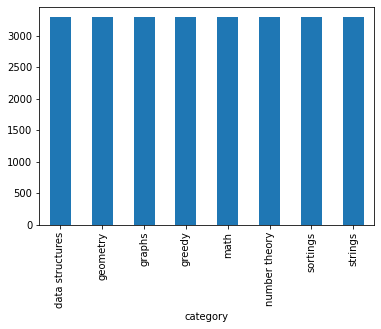

In [9]:
ros = RandomOverSampler(random_state=42)
over_sampling_df = sampleData(df, ros)
showCategories(over_sampling_df, title="RandomOverSampler")
over_sampling_df.head()

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [topicIndexMap[topic] for topic in df['category']]
        self.texts = [tokenizer(
            text,
            padding = 'max_length',
            max_length = 512, 
            truncation = True,
            return_tensors = "pt") 
        for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear_bert = nn.Linear(768, len(topicIndexMap))
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(
            input_ids = input_id, 
            attention_mask = mask, 
            return_dict = False
        )
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear_bert(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [12]:
def evaluate(title, model, test_data):
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'{title} test Accuracy: {total_acc_test / len(test_data): .3f}')
    return total_acc_test / len(test_data)

In [13]:
def getTrainValidationTestDataFrames(df):
    # Divides the dataset in 3 chunks [80%, 10%, 10%] 
    np.random.seed(123)
    df_train, df_validation, df_test = np.split(
        df,
        [int(.8*len(df)), int(.9*len(df))]
    )
    return df_train, df_validation, df_test

In [ ]:
model = BertClassifier()

checkpoint_file_name = f"{DRIVE_PATH}/training/OverSampling_4.pt"
checkpoint = torch.load(checkpoint_file_name)
model.load_state_dict(checkpoint['model_state_dict'])

df_train, df_validation, df_test = getTrainValidationTestDataFrames(over_sampling_df)

